# Tidal Project

## Step 1: Adding and formatting the data 

In [71]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [86]:
#define the filename
fname = 'ASTR19_S22_group_project_data.txt'
#open the file with read mode
f = open(fname,'r')
#read the data as a string
test_data = f.read()


#print the name of the file
print(f.name)
#print the info from the file
print(test_data)

ASTR19_S22_group_project_data.txt
#Column A: Day of the year
#Column B: Time in hours:minutes
#Column B: Tide Height in feet
 1  8:07  6.57
 1 15:37 -0.39
 2  8:55  5.38
 2 16:25 -1.74
 3  9:45  5.26
 3 17:14 -1.36
 4 10:35  4.13
 4 18:00 -1.15
 5 11:28  3.48
 5 18:46 -1.61
 6 12:22  2.62
 6 19:31  0.05
 7 13:24  1.83
 7 20:16  1.01
 8  3:22  3.57
 8 21:01  0.73
 9  4:07  4.54
 9 21:46  2.17
10  4:50  3.76
10 11:58  2.88
11  5:31  3.90
11 12:56  1.92
12  6:08  4.73
12 13:45  1.74
13  6:47  5.66
13 14:25  0.79
14  7:22  5.33
14 15:00 -0.04
15  7:59  5.23
15 15:34 -1.12
16  8:34  6.67
16 16:08 -0.61
17  9:10  4.74
17 16:41 -0.93
18  9:45  4.69
18 17:12 -1.29
19 10:21  4.20
19 17:45  0.22
20 10:57  3.68
20 18:15  0.26
21 11:38  2.47
21 18:48  0.36
22 12:25  2.59
22 19:20  0.99
23  2:22  4.10
23 19:52  1.87
24  2:58  3.17
24 20:30  1.60
25  3:37  3.71
25 10:44  3.10
26  4:23  4.04
26 11:55  2.49
27  5:15  4.07
27 12:57  2.18
28  6:09  5.93
28 13:50  0.70
29  7:05  6.89
29 14:39  0.21
30  7

<ErrorbarContainer object of 3 artists>

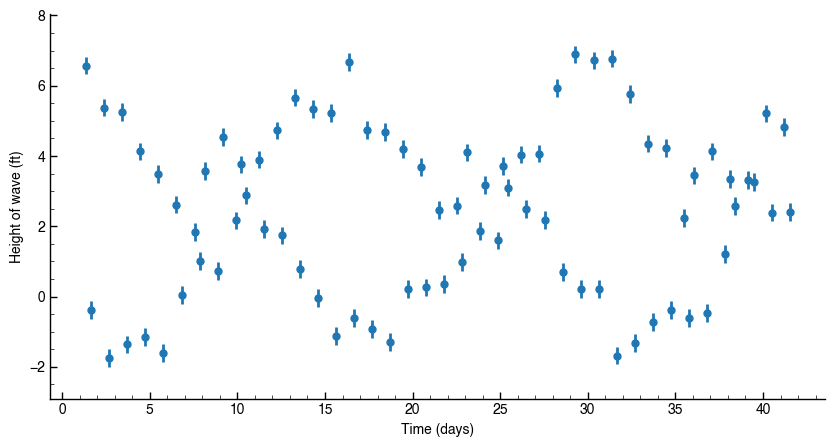

In [87]:
#open the file with numpy loadtxt
test_data = np.loadtxt(fname, dtype={'names': ('day', 'time', 'height'),'formats': ('i4', 'S5', 'f4')})

#format time to be in days then put the x and y values into two separate arrays
result_x = []
result_y = []
for item in test_data:
    day = item [0]
    time = item [1].decode()
    height = item [2]
    Day = (day)
    TimeParts = time.split(":")
    daysfromhour = int(TimeParts[0])/24
    daysfromminutes = int(TimeParts[1])/60/24
    timeindays = day + daysfromhour + daysfromminutes
    x = timeindays
    y = height
    result_x.append(x)
    result_y.append(y)
    #plt.scatter(x,y)

result_x = np.asarray(result_x)
result_y = np.asarray(result_y)

#format and create a errorbar plot of the data
plt.style.use("astr19_matplotlib_defaults.txt")
fig = plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time (days)')
plt.ylabel('Height of wave (ft)')
plt.errorbar(result_x, result_y, yerr= 0.25, fmt='o', label='data')

## Step 2: Curve fitting

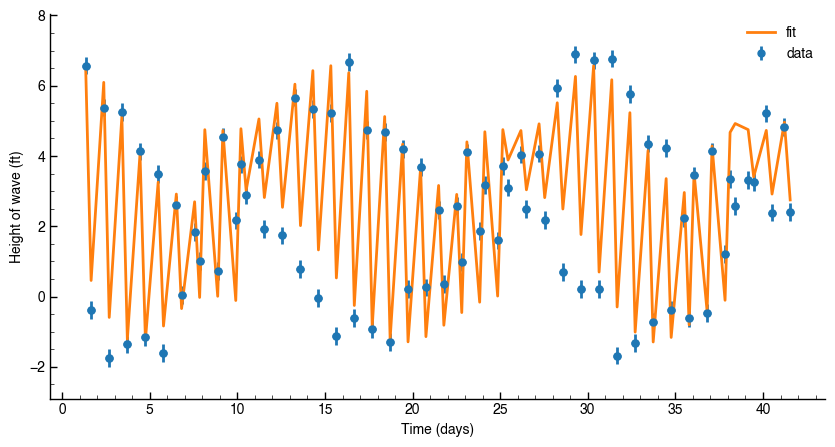

In [88]:
#define the function to fit
def f_line(x, a, b, c, d, e, f):
    return (a * np.sin(((2*np.pi)/1)*x + b+6)) + (1*c * np.sin(((2*np.pi)/0.2)*x + d+6)) * (e * np.sin(((2*np.pi)/0.5)*x + f))
    #function should be something like sinx+(sinx)(sinx) with transformations
    #(a * np.sin(b*x + c) + d) + (e * np.sin(f*x + g) + h) * (i * np.sin(j*x + k) + l) maybe


#perform the fit
params, params_cov = optimize.curve_fit(f_line, result_x, result_y, p0=[3, 0.5, 1, 1, 1, 1,]) 

a_fit = params[0]
b_fit = params[1]
c_fit = params[2]
d_fit = params[3]
e_fit = params[4]
f_fit = params[5]
#print(f'params {a_fit}, {b_fit}, {c_fit}, {d_fit}')

y_fit = (a_fit * np.sin(((np.pi)/0.5)*result_x + b_fit)+2) + (c_fit * np.cos(((2*np.pi)/0.5)*result_x + d_fit)) * (e_fit * np.sin(((2*np.pi)/0.5)*result_x + f_fit))


#plot the fit on the same graph
plt.style.use("astr19_matplotlib_defaults.txt")
fig = plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time (days)')
plt.ylabel('Height of wave (ft)')
plt.scatter(result_x, result_y)
plt.errorbar(result_x, result_y, yerr= 0.25, fmt='o', label='data')
plt.plot(result_x, y_fit, label='fit')
plt.legend(loc=0, frameon=False)



#plt.savefig('project-figure.pdf', bbox_inches='tight', dpi=600)

## Step 3: Plotting Residuals and statistical analysis

Text(0, 0.5, 'Residuals')

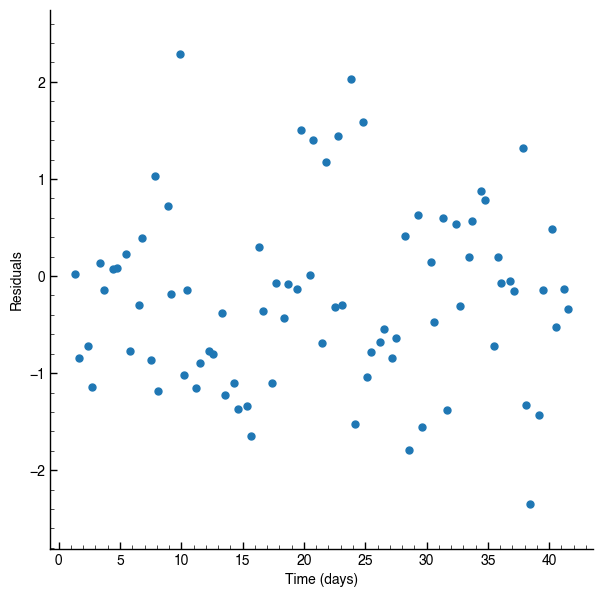

In [80]:
#define the residuals
residuals = result_y - y_fit

#create a scatter with the residuals
plt.figure(figsize=(7,7))
plt.scatter(result_x, residuals, label = "residual scatter")
plt.xlabel('Time (days)')
plt.ylabel('Residuals')

In [89]:
#Find the standard deviation of the residuals
residuals_std = np.std(residuals)
print(f'Standard Deviation of Residuals: {residuals_std:.4f}')

Standard Deviation of Residuals: 0.9064


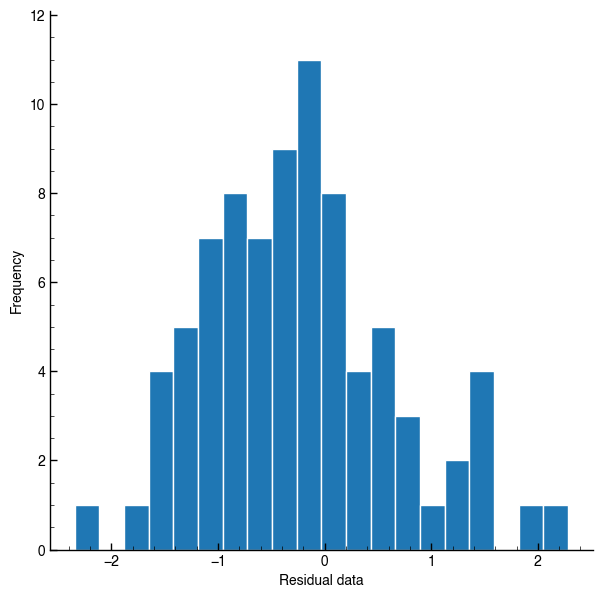

In [92]:
#Plot the residuals on a histogram 
plt.figure(figsize=(7, 7))
plt.hist(residuals, bins=20, edgecolor='white', label = "residual histogram")
plt.xlabel('Residual data')
plt.ylabel('Frequency')
plt.show()

Assess graphically and mathematically deviations of the measured tidal data from the model. Is the scatter in the data larger than the assumed experimental error? Estimate the intrinsic scatter in the data after accounting for the assumed measurement error. 



## Step 4: Outlier plotting and analysis

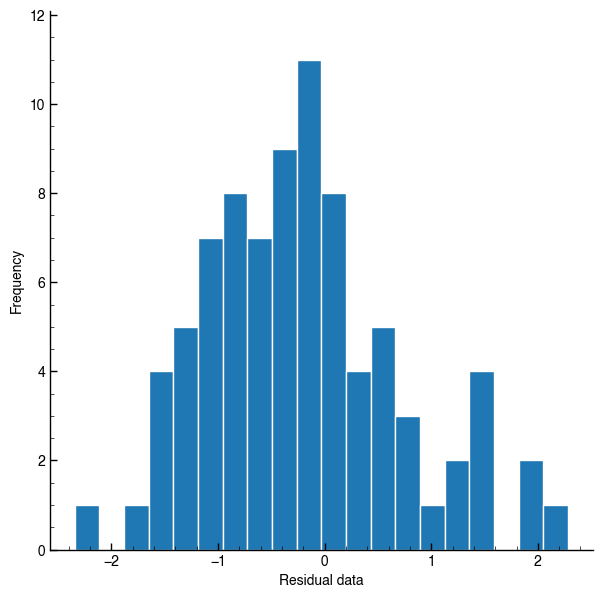

In [85]:
#Add the outlier to the data in an array
outlier_data = np.append([residuals], [2])

#plot a histogram with the new data
plt.figure(figsize=(7, 7))
plt.hist(outlier_data, bins=20, edgecolor='white', label = "outlier histogram")
plt.xlabel('Residual data')
plt.ylabel('Frequency')
plt.show()

How large of a deviation is this tsunami, in terms of standard deviations of the distribution of normal tides from the model? 

Did Part 4 clearly articulate how big the Tsunami deviation is in relation to the typical tidal pattern? Did the answer consider the standard deviations of the distribution of normal tides from the model?